### Data setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


pd.set_option('display.max_columns', None)

imputedDataset = pd.read_stata("/Users/burke.227/Documents/research/bpCog/microsim/microsim/data/fullyImputedDataset.dta")

In [2]:
import statsmodels.api as sm

imputedDataset = imputedDataset.rename({'selfReportMI' : 'mi', 
                                        'selfReportStroke' : 'stroke', 
                                        'tot_chol' : 'totChol',
                                        'meanDBP' : 'meanDbp',
                                        'meanSBP' : 'meanSbp',
                                        'age' : 'baseAge'}, axis='columns')

imputedDataset['anyDeath'] = imputedDataset.ucod >= 1
imputedDataset['nonCVDeath'] = imputedDataset.ucod == 3
imputedDataset['cvDeath'] = imputedDataset.ucod.isin([1,2])
imputedDataset = imputedDataset.loc[imputedDataset.year < 2011] # we dont' have mortality data after this time
#imputedDataset.monthsToDeath.loc[imputedDataset.anyDeath==0] = np.nan

sf1 = sm.duration.SurvfuncRight(imputedDataset.monthsToDeath, imputedDataset.nonCVDeath)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


In [3]:

#sf1.plot()

### This file has 3 separate models develoepd in it.
<ol>
<li>First, is a simple Cox model that was the primary non-cv mortalitly model used in in teh intial version of MICROSIM (nhanesMortalityModelSpec)</li>
<li>Second, a multi-level logistic regression that assigns the probability of mortality at a given age</li>
<li>Third, a cox model with time varying covariates of age </li>
</ol>

The first modle works well when compare dto NHANES over a reaosnably short time course (code at the bottom), however
it diverges over the long term when you push young peopel forward for very long periods of time. This isn't a limitation for all analyses, but its a key cavety.

So, the next two models are attempts to address that problem. I developed the TVC model first...the problem was that it is hard to get meaningful predictions out of it. So, I moved on to the multi-level logistic regresison as an alternative...

### Build Cox Mortality Model (nhanesMortalityModelSpec)

In [4]:
imputedDataset['squareBaseAge'] = imputedDataset['baseAge']**2
coxModel = sm.PHReg.from_formula("monthsToDeath ~  baseAge + squareBaseAge + a1c + bmi + gender + hdl + ldl + mi + stroke + totChol + trig + meanSbp + meanDbp + raceEthnicity + smokingStatus", status="nonCVDeath", data=imputedDataset)
results = coxModel.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: PHReg
========================================================================
Model:                      PH Reg              Sample size:       35379
Dependent variable:         monthsToDeath       Num. events:       2285 
Ties:                       Breslow                                     
------------------------------------------------------------------------
                    log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------------------
raceEthnicity[T.2] -0.0501    0.1239 0.9511 -0.4047 0.6857 0.7460 1.2125
raceEthnicity[T.3]  0.1314    0.0630 1.1404  2.0864 0.0369 1.0080 1.2902
raceEthnicity[T.4]  0.2756    0.0747 1.3174  3.6887 0.0002 1.1379 1.5252
raceEthnicity[T.5] -0.0778    0.1481 0.9251 -0.5252 0.5994 0.6920 1.2368
smokingStatus[T.1]  0.3124    0.0495 1.3667  6.3074 0.0000 1.2403 1.5060
smokingStatus[T.2]  0.9599    0.0614 2.6114 15.6319 0.0000 2.3153 2.9454
baseAge             0.0242    0.0105 1.0245  2.3050 0.0212 1.0036 1.0458
squareBaseAge       0.0005    0.0001 1.0005  5.6175 0.0000 1.0003 1.0007
a1c                 0.1414    0.0168 1.1518  8.4052 0.0000 1.1145 1.1904
bmi                -0.0079    0.0042 0.9921 -1.8953 0.0581 0.9840 1.0003
gender             -0.2983    0.0478 0.7421 -6.2392 0.0000 0.6757 0.8150
hdl                -0.0018    0.0020 0.9982 -0.9191 0.3581 0.9943 1.0021
ldl                -0.0017    0.0019 0.9983 -0.8697 0.3845 0.9946 1.0021
mi                  0.5046    0.0596 1.6563  8.4702 0.0000 1.4737 1.8614
stroke              0.3832    0.0658 1.4669  5.8270 0.0000 1.2895 1.6687
totChol             0.0014    0.0018 1.0014  0.7701 0.4413 0.9978 1.0050
trig                0.0000    0.0002 1.0000  0.2088 0.8346 0.9997 1.0004
meanSbp             0.0031    0.0010 1.0031  2.9878 0.0028 1.0011 1.0052
meanDbp            -0.0011    0.0019 0.9989 -0.5510 0.5817 0.9951 1.0027
========================================================================
Confidence intervals are for the hazard ratios
"""

### Figure out how to get baseline cumulative hazard function

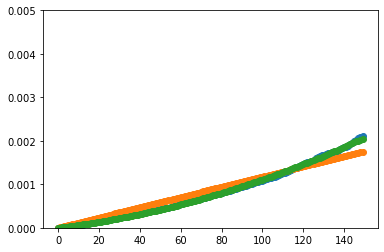

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
tuples = coxModel.baseline_cumulative_hazard(results.params)
# ok...here is a trick — the cumulative hazard curve is non linear
# applyign the 12 month cumulative hazard (repatedly, as per our plan) is going to lead to underestimation on the long-term
# to start, let's try and fit a simple linear model to the cmulative hazard curve 
# then plug that in as a baseline hazard
time = tuples[0][0]
timeYears = time/ 12
cumSurv = tuples[0][2]
cumHaz = tuples[0][1]


plt.scatter(time, cumHaz )
plt.ylim(0.000, 0.005)

model = sm.OLS(cumHaz , timeYears)
cumHazardLinearResult = model.fit()

plt.scatter(time, cumHazardLinearResult.params[0] * timeYears )

model = sm.OLS(cumHaz , np.column_stack((timeYears, timeYears**2)))
cumHazardQuadResult = model.fit()

quadOutcome = cumHazardQuadResult.params[0] * timeYears + cumHazardQuadResult.params[1] * timeYears**2
plt.scatter(time, quadOutcome)

plt.show()

### So, the quadratic (green line on top of the blue line) fits very well...export to json and use for the model

In [6]:
import sys
import os
sys.path.append(os.path.abspath("../microsim/"))
from microsim.cox_regression_model import CoxRegressionModel


coxModelExport = CoxRegressionModel(dict(zip(results.model.exog_names, results.params)),
                              dict(zip(results.model.exog_names, results.standard_errors)), 
                              cumHazardQuadResult.params[0] , cumHazardQuadResult.params[1] )

coxModelExport.write_json(os.path.abspath("../microsim/microsim/data/nhanesMortalityModelSpec.json"))

# Build logistic regression model (nhanesMortalityModelLogitSpec)

In [7]:
imputedDataset['years'] = imputedDataset['monthsToDeath'] / 12
imputedDataset['toExpand'] = np.ceil(imputedDataset.years)
expandedDataset = imputedDataset.loc[imputedDataset.index.repeat(imputedDataset.toExpand)]
expandedDataset['start'] = expandedDataset.groupby(expandedDataset.index).cumcount()
expandedDataset['age'] = expandedDataset.start + expandedDataset.baseAge
expandedDataset['stop'] = expandedDataset.start+1
expandedDataset['squareAge'] = expandedDataset['age'] **2
expandedDataset['cubeAge'] = expandedDataset['age'] **3

expandedDataset.loc[expandedDataset.stop > expandedDataset.years, 'stop'] = expandedDataset.loc[expandedDataset.stop > expandedDataset.years].years

In [8]:
ctvDF = expandedDataset[['index', 'start', 'stop', 'nonCVDeath' ,'age', 'squareAge', 'cubeAge', 'a1c', 'bmi', 'gender', 'hdl', 'ldl', 'mi', 'stroke', 'totChol', 'trig', 'meanSbp', 'meanDbp','raceEthnicity', 'smokingStatus']]
ctvDF.loc[:, 'raceEthnicity'] = ctvDF.raceEthnicity.astype('int')
ctvDF.loc[:, 'smokingStatus'] = ctvDF.smokingStatus.astype('int')
ctvDF.loc[:, 'nonCVDeath'] = ctvDF.nonCVDeath.astype('int')


ctvDF.to_stata('cvtDF.dta')

/Users/burke.227/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [9]:
import statsmodels.formula.api as smf

baseModel = smf.logit('nonCVDeath ~ age + a1c + bmi + gender + hdl + ldl + mi + stroke + totChol + trig + meanSbp + meanDbp + raceEthnicity + smokingStatus', ctvDF)
squareModel = smf.logit('nonCVDeath ~ age + squareAge+ a1c + bmi + gender + hdl + ldl + mi + stroke + totChol + trig + meanSbp + meanDbp + raceEthnicity + smokingStatus', ctvDF)
cubeModel = smf.logit('nonCVDeath ~ age + squareAge + cubeAge + a1c + bmi + gender + hdl + ldl + mi + stroke + totChol + trig + meanSbp + meanDbp + raceEthnicity + smokingStatus', ctvDF)


In [10]:
baseModel.fit().summary()

Optimization terminated successfully.
         Current function value: 0.145722
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             nonCVDeath   No. Observations:               242277
Model:                          Logit   Df Residuals:                   242262
Method:                           MLE   Df Model:                           14
Date:                Fri, 13 May 2022   Pseudo R-squ.:                  0.2284
Time:                        10:57:31   Log-Likelihood:                -35305.
converged:                       True   LL-Null:                       -45757.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -9.0271      0.130    -69.665      0.000      -9.281      -8.773
age               0.0718      0.001     83.674      0.000       0.070       0.074
a1c               0.1371      0.008     16.545      0.000       0.121       0.153
bmi              -0.0147      0.002     -7.509      0.000      -0.018      -0.011
gender           -0.2534      0.023    -11.076      0.000      -0.298      -0.209
hdl              -0.0051      0.001     -5.177      0.000      -0.007      -0.003
ldl              -0.0014      0.001     -1.527      0.127      -0.003       0.000
mi                0.5599      0.032     17.329      0.000       0.497       0.623
stroke            0.3318      0.036      9.093      0.000       0.260       0.403
totChol           0.0025      0.001      2.879      0.004       0.001       0.004
trig             -0.0002   9.54e-05     -1.894      0.058      -0.000    6.34e-06
meanSbp           0.0104      0.001     20.222      0.000       0.009       0.011
meanDbp          -0.0049      0.001     -5.219      0.000      -0.007      -0.003
raceEthnicity     0.0330      0.010      3.201      0.001       0.013       0.053
smokingStatus     0.4204      0.014     29.020      0.000       0.392       0.449
=================================================================================
"""

In [11]:
squareModel.fit().summary()

Optimization terminated successfully.
         Current function value: 0.145622
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             nonCVDeath   No. Observations:               242277
Model:                          Logit   Df Residuals:                   242261
Method:                           MLE   Df Model:                           15
Date:                Fri, 13 May 2022   Pseudo R-squ.:                  0.2290
Time:                        10:57:32   Log-Likelihood:                -35281.
converged:                       True   LL-Null:                       -45757.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.1589      0.174    -46.917      0.000      -8.500      -7.818
age               0.0371      0.005      7.511      0.000       0.027       0.047
squareAge         0.0003   3.89e-05      7.082      0.000       0.000       0.000
a1c               0.1453      0.008     17.373      0.000       0.129       0.162
bmi              -0.0130      0.002     -6.600      0.000      -0.017      -0.009
gender           -0.2588      0.023    -11.281      0.000      -0.304      -0.214
hdl              -0.0050      0.001     -5.144      0.000      -0.007      -0.003
ldl              -0.0015      0.001     -1.616      0.106      -0.003       0.000
mi                0.5646      0.032     17.393      0.000       0.501       0.628
stroke            0.3285      0.037      8.959      0.000       0.257       0.400
totChol           0.0027      0.001      3.057      0.002       0.001       0.004
trig             -0.0002   9.53e-05     -1.931      0.053      -0.000    2.72e-06
meanSbp           0.0101      0.001     19.531      0.000       0.009       0.011
meanDbp          -0.0039      0.001     -4.083      0.000      -0.006      -0.002
raceEthnicity     0.0312      0.010      3.013      0.003       0.011       0.051
smokingStatus     0.4371      0.015     29.723      0.000       0.408       0.466
=================================================================================
"""

In [12]:
cubeModel.fit().summary()

Optimization terminated successfully.
         Current function value: 0.145578
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             nonCVDeath   No. Observations:               242277
Model:                          Logit   Df Residuals:                   242260
Method:                           MLE   Df Model:                           16
Date:                Fri, 13 May 2022   Pseudo R-squ.:                  0.2292
Time:                        10:57:32   Log-Likelihood:                -35270.
converged:                       True   LL-Null:                       -45757.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.6171      0.368    -17.983      0.000      -7.338      -5.896
age              -0.0542      0.020     -2.691      0.007      -0.094      -0.015
squareAge         0.0019      0.000      5.402      0.000       0.001       0.003
cubeAge        -8.82e-06   1.91e-06     -4.623      0.000   -1.26e-05   -5.08e-06
a1c               0.1448      0.008     17.259      0.000       0.128       0.161
bmi              -0.0130      0.002     -6.627      0.000      -0.017      -0.009
gender           -0.2530      0.023    -11.013      0.000      -0.298      -0.208
hdl              -0.0051      0.001     -5.164      0.000      -0.007      -0.003
ldl              -0.0014      0.001     -1.548      0.122      -0.003       0.000
mi                0.5606      0.032     17.277      0.000       0.497       0.624
stroke            0.3258      0.037      8.895      0.000       0.254       0.398
totChol           0.0027      0.001      3.074      0.002       0.001       0.004
trig             -0.0002   9.55e-05     -1.956      0.050      -0.000    3.55e-07
meanSbp           0.0099      0.001     19.206      0.000       0.009       0.011
meanDbp          -0.0034      0.001     -3.588      0.000      -0.005      -0.002
raceEthnicity     0.0326      0.010      3.148      0.002       0.012       0.053
smokingStatus     0.4410      0.015     29.907      0.000       0.412       0.470
=================================================================================
"""

In [13]:
ctvDF['baseProbs'] = baseModel.fit().predict(ctvDF)
ctvDF['squareProbs'] = squareModel.fit().predict(ctvDF)
ctvDF['cubeProbs'] = cubeModel.fit().predict(ctvDF)

Optimization terminated successfully.
         Current function value: 0.145722
         Iterations 9


/var/folders/wd/wlg9qv65701fzmgdkdfy5vtm0000gr/T/ipykernel_86405/1164248652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctvDF['baseProbs'] = baseModel.fit().predict(ctvDF)


Optimization terminated successfully.
         Current function value: 0.145622
         Iterations 10


/var/folders/wd/wlg9qv65701fzmgdkdfy5vtm0000gr/T/ipykernel_86405/1164248652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctvDF['squareProbs'] = squareModel.fit().predict(ctvDF)


Optimization terminated successfully.
         Current function value: 0.145578
         Iterations 10


/var/folders/wd/wlg9qv65701fzmgdkdfy5vtm0000gr/T/ipykernel_86405/1164248652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctvDF['cubeProbs'] = cubeModel.fit().predict(ctvDF)


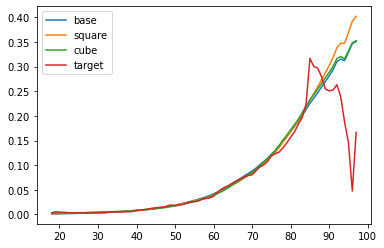

In [14]:
#plt.plot(lifeTable.Age, lifeTable.meanSurvProb, label='lifetable')

baseGB = ctvDF.groupby('age')['baseProbs'].mean()
squareGB = ctvDF.groupby('age')['squareProbs'].mean()
cubeGB = ctvDF.groupby('age')['cubeProbs'].mean()

plt.plot(baseGB.index, baseGB.values, label='base')
plt.plot(squareGB.index, squareGB.values, label='square')
plt.plot(cubeGB.index, cubeGB.values, label='cube')

nonCVDeathGB = ctvDF.groupby('age')['nonCVDeath'].mean()
plt.plot(nonCVDeathGB.index, nonCVDeathGB.values, label='target')

plt.legend()

In [15]:
import stata_setup
stata_setup.config('/Applications/Stata', 'mp')

from pystata import config
config.init('mp')


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 8-core  perpetual
Serial number: 501706362670
  Licensed to: Burke, Jim
               Ohio State

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


In [16]:
ctvDF.head()

,index,start,stop,nonCVDeath,age,squareAge,cubeAge,a1c,bmi,gender,hdl,ldl,mi,stroke,totChol,trig,meanSbp,meanDbp,raceEthnicity,smokingStatus,baseProbs,squareProbs,cubeProbs
11856,0,0,1.0000,0,62.0000,3844.0000,238328.0000,5.7000,58.0400,2.0000,47.0000,90.0000,1,0,179.0000,88.0000,123.3333,60.6667,5,0,0.0331,0.0316,0.0309
11856,0,1,2.0000,0,63.0000,3969.0000,250047.0000,5.7000,58.0400,2.0000,47.0000,90.0000,1,0,179.0000,88.0000,123.3333,60.6667,5,0,0.0355,0.0338,0.0333
11856,0,2,3.0000,0,64.0000,4096.0000,262144.0000,5.7000,58.0400,2.0000,47.0000,90.0000,1,0,179.0000,88.0000,123.3333,60.6667,5,0,0.0381,0.0363,0.0359
11856,0,3,4.0000,0,65.0000,4225.0000,274625.0000,5.7000,58.0400,2.0000,47.0000,90.0000,1,0,179.0000,88.0000,123.3333,60.6667,5,0,0.0408,0.0389,0.0387
11856,0,4,4.3333,0,66.0000,4356.0000,287496.0000,5.7000,58.0400,2.0000,47.0000,90.0000,1,0,179.0000,88.0000,123.3333,60.6667,5,0,0.0437,0.0417,0.0417


In [17]:
#from pystata import stata
#stata.pdataframe_to_data(ctvDF, True)
#stata.run('logit nonCVDeath age c.age#c.age a1c bmi gender hdl ldl mi stroke totChol trig meanSbp meanDbp i.raceEthnicity i.smokingStatus', echo=True)

In [25]:
import statsmodels.formula.api as smf
ctvDF['squareAge'] = ctvDF.age **2

logitfit = smf.logit(formula = "nonCVDeath ~ age + squareAge +  a1c + bmi + gender + hdl + ldl + mi + stroke + totChol + trig + meanSbp + meanDbp + C(raceEthnicity) + C(smokingStatus)", data = ctvDF).fit()

/var/folders/wd/wlg9qv65701fzmgdkdfy5vtm0000gr/T/ipykernel_86405/264412431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctvDF['squareAge'] = ctvDF.age **2


Optimization terminated successfully.
         Current function value: 0.145331
         Iterations 10


In [ ]:
#ereturn = stata.get_ereturn()

In [33]:
#stata.run('melogit nonCVDeath age  c.age#c.age a1c bmi gender hdl ldl mi stroke totChol trig meanSbp meanDbp i.raceEthnicity i.smokingStatus || level_0:', echo=False)

In [32]:
#stata.run('estat sd')
#randomInterceptSD = stata.get_return()['r(b)'][-1][-1]

In [31]:
#coeffLabels = ['age', 'squareAge', 'a1c', 'bmi', 'gender', 'hdl', 'ldl', 'mi', 'stroke', 'totChol', 
#               'trig', 'meanSBP', 'meanDBP', 'raceEthnicity[T.2]', 'raceEthnicity[T.3]', 'raceEthnicity[T.4]',
#              'raceEthnicity[T.5]', 'smokingStatus[T.1]', 'smokingStatus[T.2]', 'Intercept']

##rawParams = stata.get_ereturn()['e(b)'][0]
#rawParams = [param for param in rawParams if param != 0]
#params = {paramName: rawParams[i] for i, paramName in enumerate(coeffLabels)}
#rawSES = [np.sqrt(stata.get_ereturn()['e(V)'][i][i]) for i in range(len(stata.get_ereturn()['e(V)'][0]))]
#rawSES = [se for se in rawSES if se != 0]
#ses = {paramName: rawSES[i] for i, paramName in enumerate(coeffLabels)}

In [28]:
#import os
#os.chdir("/Users/burke.227/Documents/research/bpCog/microsim/")#
#
#from microsim.cox_regression_model import CoxRegressionModel
#
#logitModelExport = CoxRegressionModel(params, ses, 0, randomInterceptSD )
#
#logitModelExport.write_json(os.path.abspath("../microsim/microsim/data/nhanesMortalityModelRandomInterceptLogitSpec.json"))

In [27]:
#import os
#os.chdir("/Users/burke.227/Documents/research/bpCog/microsim/")
#
#from microsim.cox_regression_model import CoxRegressionModel
#
#squareModelFit = squareModel.fit()
#
#logitModelExport = CoxRegressionModel(dict(squareModelFit.params), dict(squareModelFit.bse), 0, 0 )
#
#logitModelExport.write_json(os.path.abspath("../microsim/microsim/data/nhanesMortalityModelLogitSpec.json"))

In [51]:
import os
os.chdir("/Users/burke.227/Documents/research/bpCog/microsim/")

from microsim.cox_regression_model import CoxRegressionModel

squareModelFit = squareModel.fit()

filterParams = {key[2:key.index(")")]+key[key.index(")")+1:] if "C(" in key else key : value for key, value in logitfit.params.iteritems()}
filterSES = {key[2:key.index(")")]+key[key.index(")")+1:] if "C(" in key else key : value for key, value in logitfit.bse.iteritems()}


logitModelExport = CoxRegressionModel(filterParams, filterSES, 0, 0 )

logitModelExport.write_json(os.path.abspath("../microsim/microsim/data/nhanesMortalityModelLogitSpec.json"))

Optimization terminated successfully.
         Current function value: 0.145622
         Iterations 10


In [49]:
{key[2:key.index(")")]+key[key.index(")")+1:] if "C(" in key else key : value for key, value in logitfit.params.iteritems()}

{'Intercept': -8.139482003729967,
 'raceEthnicity[T.2]': -0.28624726613419843,
 'raceEthnicity[T.3]': 0.08494102920243225,
 'raceEthnicity[T.4]': 0.14192215545324638,
 'raceEthnicity[T.5]': -0.25871549254433457,
 'smokingStatus[T.1]': 0.2779998096422532,
 'smokingStatus[T.2]': 0.9157348787976075,
 'age': 0.03961553933186139,
 'squareAge': 0.0002643453181544624,
 'a1c': 0.14698401037674425,
 'bmi': -0.012996748021874225,
 'gender': -0.2860531102237226,
 'hdl': -0.005577883767459247,
 'ldl': -0.002019210657264125,
 'mi': 0.5660562759035446,
 'stroke': 0.3210729955939669,
 'totChol': 0.003110916972025477,
 'trig': -0.00017887713134773307,
 'meanSbp': 0.009983247511564852,
 'meanDbp': -0.003999195017998322}

In [46]:
type(logitfit.params)

pandas.core.series.Series

### Recalibrating the mortality model to the population

In [37]:
# push these functions to population

def process_person(person, pop, denominator, numerator):
    for i, personAge in enumerate(person._age):
        denominator[int(personAge)]= denominator[int(personAge)]+1
        if i==pop._currentWave:
            break

        diedAtAge = not person._alive[i+1]
        if diedAtAge:
            numerator[int(personAge)]= numerator[int(personAge)]+1
            break

def prob_mortality_by_age(pop):
    denominatorForAgeMale = {i : 0 for i in range(18, 200)}
    numeratorForAgeMale = {i : 0 for i in range(18, 200)}
    denominatorForAgeFemale = {i : 0 for i in range(18, 200)}
    numeratorForAgeFemale = {i : 0 for i in range(18, 200)}

    for i, person in pop._people.iteritems():
        if int(person._gender) ==2:
            process_person(person, pop, denominatorForAgeFemale, numeratorForAgeFemale)
        else:
            process_person(person, pop, denominatorForAgeMale, numeratorForAgeMale)

    denominatorForAgeMale = {i : x for i, x in denominatorForAgeMale.items() if x > 0}
    denominatorForAgeFemale = {i : x for i, x in denominatorForAgeFemale.items() if x > 0}
    male = {age : numeratorForAgeMale[age] / rate for age, rate in denominatorForAgeMale.items()}
    female =  {age : numeratorForAgeFemale[age] / rate for age, rate in denominatorForAgeFemale.items()}
    
    maleMortalityDF = pd.DataFrame({'age' : male.keys(), 'mortality': male.values()})
    femaleMortalityDF = pd.DataFrame({'age' : female.keys(), 'mortality': female.values()})

    return maleMortalityDF,femaleMortalityDF
                
#baseMortalityByAgeMale, baseMortalityByAgeFemale = prob_mortality_by_age(basePop)
#modMortalityByAgeMale, modMortalityByAgeFemale = prob_mortality_by_age(modPop)
            

In [38]:
lifeTable = pd.read_excel('/Users/burke.227/Documents/research/bpCog/nhanes/probSurvLifeTables_ss2019.xlsx')
lifeTable['meanSurvProb'] = (lifeTable.maleProbSurv + lifeTable.femaleProbSurv)/2

In [39]:
import os
os.chdir("/Users/burke.227/Documents/research/bpCog/microsim/")
from microsim.population import NHANESDirectSamplePopulation
import logging
logging.basicConfig(level=logging.INFO)

from microsim.data_loader import load_model_spec
from microsim.regression_model import RegressionModel 
from microsim.statsmodel_rand_intercept_logistic_risk_factor_model import StatsModelRandInterceptLogisticRiskFactorModel
from microsim.statsmodel_logistic_risk_factor_model import StatsModelLogisticRiskFactorModel

from microsim.outcome_model_type import OutcomeModelType

In [40]:
minCompareAge = 18
maxCompareAge = 100

def compare_to_life_table(male, female, lifeTable):
    lifeTableTrunc = lifeTable.iloc[minCompareAge:maxCompareAge].copy(deep=True)
    lifeTableTrunc.rename(columns={'Age' : 'age'}, inplace=True)
    lifeTableTrunc = pd.merge(lifeTableTrunc, male, on='age')
    lifeTableTrunc.rename(columns={'mortality' : 'maleMortalityPop'}, inplace=True)
    lifeTableTrunc = pd.merge(lifeTableTrunc, female, on='age')
    lifeTableTrunc.rename(columns={'mortality' : 'femaleMortalityPop'}, inplace=True)
    
    lifeTableTrunc['diffsMale'] = lifeTableTrunc.maleProbSurv - lifeTableTrunc.maleMortalityPop
    lifeTableTrunc['diffsFemale'] = lifeTableTrunc.femaleProbSurv - lifeTableTrunc.femaleMortalityPop
    lifeTableTrunc['squareDiffsMale'] = lifeTableTrunc['diffsMale']**2
    lifeTableTrunc['squareDiffsFemale'] = lifeTableTrunc['diffsFemale']**2
    lifeTableTrunc['sumSquares'] = lifeTableTrunc['squareDiffsMale'] + lifeTableTrunc['squareDiffsFemale']
    return lifeTableTrunc['sumSquares'].sum(), lifeTableTrunc

def plot_pop(pop, label="", cap=200):
    male, female = prob_mortality_by_age(pop)
    combined = male
    combined.rename(columns={'mortality' : 'maleMortality'}, inplace=True)
    combined['femaleMortality'] = female['mortality']

    combined['combinedMortality'] = (combined['maleMortality'] + combined['femaleMortality'] ) /2
    combinedCap = combined.loc[combined.age < cap]
    plt.plot(combinedCap.age, combinedCap.combinedMortality, label=label)
    return combinedCap

def get_pop_mortality_deviation(pop, lifeTable):
    mortByAgeMale, mortByAgeFemale = prob_mortality_by_age(pop)
    return compare_to_life_table(mortByAgeMale, mortByAgeFemale, lifeTable)


In [98]:
squaresForParams = {}
weightedConstrainedSquaresForParams = {}
popsForParams = {}
lifeTableComparatorForParams = {}

for ageMult in [-1.3, -1.2, -1.1, -1]:
    for ageSquareMult in [3.8, 3.9, 4.0, 4.1, 4.2]:

        print(f"Age mult: {ageMult}, square mult: {ageSquareMult}")
        pop = NHANESDirectSamplePopulation(15000, 1999) 

        nonCVModelSpec = load_model_spec('nhanesMortalityModelLogit')
        mortModel = StatsModelLogisticRiskFactorModel(
            RegressionModel(**nonCVModelSpec), False)
        
        mortModel.non_intercept_params['age'] = mortModel.non_intercept_params['age'] * ageMult 
        mortModel.non_intercept_params['squareAge'] = mortModel.non_intercept_params['squareAge'] * ageSquareMult

        pop._outcome_model_repository._models[OutcomeModelType.NON_CV_MORTALITY] = mortModel

        popAlive, popDF = pop.advance_vectorized(100)
        sumSquares, lifeTableTrunc = get_pop_mortality_deviation(pop, lifeTable)
        squaresForParams[(ageMult, ageSquareMult)] = sumSquares

        lifeTableTrunc['diffInverseWeightedByAge'] = lifeTableTrunc['sumSquares'] * 1/lifeTableTrunc.age
        weightedConstrainedSquaresForParams[(ageMult, ageSquareMult)] = lifeTableTrunc['diffInverseWeightedByAge'].sum()  
        lifeTableComparatorForParams[(ageMult, ageSquareMult)] = lifeTableTrunc
        
        popsForParams[(ageMult, ageSquareMult)] = pop

Age mult: -1.3, square mult: 3.8


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
/Users/burke.227/Documents/research/bpCog/microsim/microsim/gfr_equation.py:72: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993 ** x.age
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:pr

Age mult: -1.3, square mult: 3.9


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.3, square mult: 4.0


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.3, square mult: 4.1


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.3, square mult: 4.2


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.2, square mult: 3.8


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.2, square mult: 3.9


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.2, square mult: 4.0


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.2, square mult: 4.1


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.2, square mult: 4.2


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.1, square mult: 3.8


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.1, square mult: 3.9


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.1, square mult: 4.0


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.1, square mult: 4.1


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1.1, square mult: 4.2


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1, square mult: 3.8


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1, square mult: 3.9


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1, square mult: 4.0


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1, square mult: 4.1


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

Age mult: -1, square mult: 4.2


INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

In [104]:
fitDF = pd.DataFrame({'linear' : [key[0] for key in squaresForParams.keys()], 
                      'quad' : [key[1] for key in squaresForParams.keys()],
                     'diff' : [val for val in weightedConstrainedSquaresForParams.values()]})
fitDF.sort_values('diff', inplace=True, ascending=True)

In [102]:
fitDF.iloc[0:6]

,linear,quad,diff
14,-1.1000,4.2000,0.0001
17,-1.0000,4.0000,0.0001
13,-1.1000,4.1000,0.0003
18,-1.0000,4.1000,0.0004
16,-1.0000,3.9000,0.0005
9,-1.2000,4.2000,0.0006


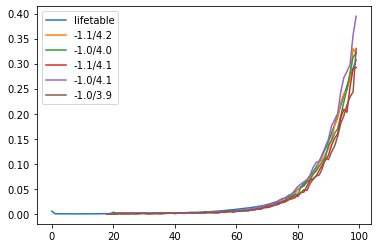

In [106]:
lifeTableCap100 = lifeTable.loc[lifeTable.Age < 100 ]
plt.plot(lifeTableCap100.Age, lifeTableCap100.meanSurvProb, label='lifetable')
for i, x in fitDF.iloc[0:5].iterrows():
    plot_pop(popsForParams[(x.linear,x.quad)], f"{x.linear}/{x.quad}", 100)

plt.legend(loc='upper left')

In [117]:
print(f"Overall mortality: {popsForParams[-1, 4].calculate_mean_age_sex_standardized_mortality(2000)}")

/Users/burke.227/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/Users/burke.227/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/burke.227/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Overall mortality: 980.7409153475336


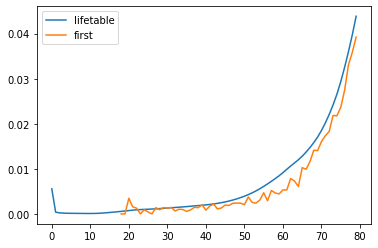

In [116]:
lifeTableCap100 = lifeTable.loc[lifeTable.Age < 80]
plt.plot(lifeTableCap100.Age, lifeTableCap100.meanSurvProb, label='lifetable')
plot_pop(popsForParams[(-1, 4)], f"first", 80)



plt.legend(loc='upper left')

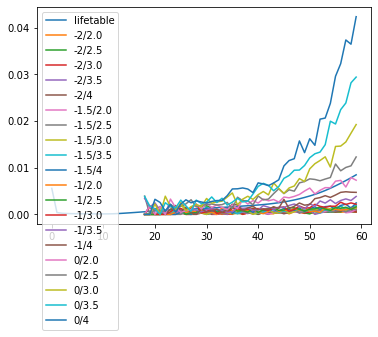

In [92]:
lifeTableCap100 = lifeTable.loc[lifeTable.Age < 60]
plt.plot(lifeTableCap100.Age, lifeTableCap100.meanSurvProb, label='lifetable')
for key, pop in popsForParams.items():
    plot_pop(pop, f"{key[0]}/{key[1]}", 60)

plt.legend(loc='upper left')

In [ ]:
### Upshot - baseline mortality model derived in NHANES, badly underpredicts late life mortality, but recalibration
### leads to close align

In [10]:
baseAlive, baseDF = basePop.advance_vectorized(100)

INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

In [5]:
modPop = NHANESDirectSamplePopulation(1000, 1999) 

nonCVModelSpec = load_model_spec('nhanesMortalityModelLogit')
modPop._outcome_model_repository._models[OutcomeModelType.NON_CV_MORTALITY] = StatsModelRandInterceptLogisticRiskFactorModel(
    RegressionModel(**nonCVModelSpec), False, 'nonCVMortality')

modAlive, modDF = modPop.advance_vectorized(100)

INFO:root:processing year: 0
INFO:root:processing year: 1
INFO:root:processing year: 2
INFO:root:processing year: 3
INFO:root:processing year: 4
INFO:root:processing year: 5
INFO:root:processing year: 6
INFO:root:processing year: 7
INFO:root:processing year: 8
INFO:root:processing year: 9
INFO:root:processing year: 10
INFO:root:processing year: 11
INFO:root:processing year: 12
INFO:root:processing year: 13
INFO:root:processing year: 14
INFO:root:processing year: 15
INFO:root:processing year: 16
INFO:root:processing year: 17
INFO:root:processing year: 18
INFO:root:processing year: 19
INFO:root:processing year: 20
INFO:root:processing year: 21
INFO:root:processing year: 22
INFO:root:processing year: 23
INFO:root:processing year: 24
INFO:root:processing year: 25
INFO:root:processing year: 26
INFO:root:processing year: 27
INFO:root:processing year: 28
INFO:root:processing year: 29
INFO:root:processing year: 30
INFO:root:processing year: 31
INFO:root:processing year: 32
INFO:root:processing

In [16]:
modAlive.age.describe()

count   111.0000
mean    130.0901
std       8.7048
min     118.0000
25%     123.0000
50%     129.0000
75%     136.0000
max     159.0000
Name: age, dtype: float64

In [17]:
baseAlive.age.describe()

count   211.0000
mean    130.7773
std       9.0844
min     118.0000
25%     123.0000
50%     129.0000
75%     137.0000
max     161.0000
Name: age, dtype: float64

In [24]:
### nxt step...look at mortality in the cox model for NHANES vs. the logit model within NHANEs
### then compare to life tables for the population...see which is closer to the ballpark...ultimatley...we might have to recalibrate...


# Time-varying cox model (nhanesMortalityModelSpecTVC) This is all archived code — tried to fit a time-varying model to the data...and, while the model fits ok, I can't figure out how to get predictions at given time points otu of it...so, I switched to tryign the multi-level logistic regression as an alternative...

In [8]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter(penalizer=0.1)

In [435]:
# merge in dummies
dummyCols = pd.get_dummies(ctvDF[['raceEthnicity', 'smokingStatus']], drop_first=True)
colMapper = {}
for col in dummyCols.columns:
   colMapper[col] = col[:-2] + str("[T.") + col[-1:] + ']'
dummyCols.rename(columns=colMapper, inplace=True)
ctvDF = ctvDF.join(dummyCols)

ValueError: columns overlap but no suffix specified: Index(['raceEthnicity[T.2]', 'raceEthnicity[T.3]', 'raceEthnicity[T.4]',
       'raceEthnicity[T.5]', 'smokingStatus[T.1]', 'smokingStatus[T.2]'],
      dtype='object')

Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -890996.49721, newton_decrement = 0.00000, seconds_since_start = 21.1Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 2083083 periods, 10696 subjects, 76603 events>
         event col = 'nonCVDeath'
         penalizer = 0.1
number of subjects = 10696
 number of periods = 2083083
  number of events = 76603
partial log-likelihood = -890996.50
  time fit was run = 2022-04-21 21:24:27 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
a1c                  0.08       1.09       0.00             0.08             0.09                 1.08                 1.09
age                  0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
bmi                 -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gender              -0.08       0.93       0.00            -0.08            -0.07                 0.92                 0.93
hdl                 -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ldl                  0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
meanDbp             -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
meanSbp              0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
mi                   0.48       1.61       0.01             0.46             0.49                 1.58                 1.64
raceEthnicity[T.2]  -0.07       0.93       0.01            -0.09            -0.06                 0.91                 0.95
raceEthnicity[T.3]   0.08       1.08       0.00             0.07             0.09                 1.07                 1.09
raceEthnicity[T.4]  -0.01       0.99       0.00            -0.02             0.00                 0.98                 1.00
raceEthnicity[T.5]  -0.07       0.93       0.01            -0.09            -0.06                 0.91                 0.95
smokingStatus[T.1]   0.11       1.12       0.00             0.10             0.12                 1.11                 1.13
smokingStatus[T.2]   0.10       1.11       0.00             0.09             0.11                 1.09                 1.12
squareAge            0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
stroke               0.36       1.44       0.01             0.34             0.38                 1.41                 1.47
totChol              0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
trig                 0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

                     cmp to      z      p   -log2(p)
covariate                                           
a1c                    0.00  45.30 <0.005        inf
age                    0.00 116.99 <0.005        inf
bmi                    0.00 -11.09 <0.005      92.56
gender                 0.00 -20.23 <0.005     299.98
hdl                    0.00  -6.18 <0.005      30.51
ldl                    0.00   6.54 <0.005      33.94
meanDbp                0.00  -9.74 <0.005      72.07
meanSbp                0.00  80.65 <0.005        inf
mi                     0.00  52.24 <0.005        inf
raceEthnicity[T.2]     0.00  -8.40 <0.005      54.37
raceEthnicity[T.3]     0.00  20.67 <0.005     312.87
raceEthnicity[T.4]     0.00  -1.51   0.13       2.94
raceEthnicity[T.5]     0.00  -7.60 <0.005      44.95
smokingStatus[T.1]     0.00  25.33 <0.005     467.93
smokingStatus[T.2]     0.00  20.71 <0.005     314.20
squareAge              0.00 136.04 <0.005        inf
stroke                 0.00  35.43 <0.005     911.21
totChol                0.00   8.70 <0.005      58.01
trig           

<AxesSubplot:xlabel='log(HR) (95% CI)'>

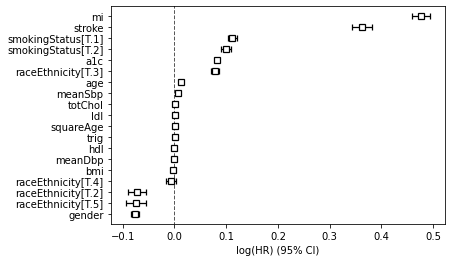

In [436]:
ctv.fit(ctvDF, id_col="index", event_col="nonCVDeath", start_col="start", stop_col="stop", 
        formula="age + squareAge + a1c + bmi + gender + hdl + ldl + mi + stroke + totChol + trig + meanSbp + meanDbp + raceEthnicity + smokingStatus",
        show_progress=True)
ctv.print_summary()
ctv.plot()

In [447]:
dict(ctv.params_)

{'a1c': 0.08183054440782692,
 'age': 0.011926239904686844,
 'bmi': -0.0033273578573929006,
 'gender': -0.07650415094431486,
 'hdl': -0.0007391758976968744,
 'ldl': 0.00033952357107604577,
 'meanDbp': -0.0015702441171091387,
 'meanSbp': 0.007462542338004965,
 'mi': 0.476499590090582,
 'raceEthnicity[T.2]': -0.07218985250452976,
 'raceEthnicity[T.3]': 0.07897001314630409,
 'raceEthnicity[T.4]': -0.00717472250919397,
 'raceEthnicity[T.5]': -0.07483772917701186,
 'smokingStatus[T.1]': 0.11183237408835181,
 'smokingStatus[T.2]': 0.10008875342488553,
 'squareAge': 0.00012918351173075526,
 'stroke': 0.3627580288674361,
 'totChol': 0.00039280982327966567,
 'trig': 7.38208761898265e-05}

In [452]:
np.exp(pd.Series(dict(ctv.params_)))

a1c                  1.085272
age                  1.011998
bmi                  0.996678
gender               0.926349
hdl                  0.999261
ldl                  1.000340
meanDbp              0.998431
meanSbp              1.007490
mi                   1.610427
raceEthnicity[T.2]   0.930354
raceEthnicity[T.3]   1.082172
raceEthnicity[T.4]   0.992851
raceEthnicity[T.5]   0.927894
smokingStatus[T.1]   1.118325
smokingStatus[T.2]   1.105269
squareAge            1.000129
stroke               1.437288
totChol              1.000393
trig                 1.000074
dtype: float64

In [ ]:
ctvDF.loc[:,'partialHazard'] = ctv.predict_partial_hazard(ctvDF)

In [453]:
import statsmodels.formula.api as smf
logitfit = smf.ols(formula = 'partialHazard ~ age*stop + squareAge*stop + age + squareAge + a1c + bmi + gender + hdl + ldl + mi + stroke + totChol + trig + meanSbp + meanDbp + raceEthnicity + smokingStatus -1 ', data = ctvDF).fit()
logitfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          partialHazard   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                 1.532e+06
Date:                Thu, 21 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:31:29   Log-Likelihood:            -1.6702e+05
No. Observations:             2083083   AIC:                         3.341e+05
Df Residuals:                 2083060   BIC:                         3.344e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
raceEthnicity[1]      -0.7740      0.003   -257.752      0.000      -0.780      -0.768
raceEthnicity[2]      -0.8301      0.003   -269.089      0.000      -0.836      -0.824
raceEthnicity[3]      -0.6633      0.003   -222.544      0.000      -0.669      -0.657
raceEthnicity[4]      -0.8018      0.003   -262.468      0.000      -0.808      -0.796
raceEthnicity[5]      -0.8716      0.003   -278.646      0.000      -0.878      -0.865
smokingStatus[T.1]     0.1759      0.000    360.353      0.000       0.175       0.177
smokingStatus[T.2]     0.1090      0.000    219.315      0.000       0.108       0.110
age                   -0.0477      0.000   -451.536      0.000      -0.048      -0.048
stop                   0.0798      0.000    183.606      0.000       0.079       0.081
age:stop              -0.0027   1.78e-05   -152.660      0.000      -0.003      -0.003
squareAge              0.0008   1.04e-06    748.139      0.000       0.001       0.001
squareAge:stop      2.263e-05   1.66e-07    135.980      0.000    2.23e-05     2.3e-05
a1c                    0.1405      0.000    670.861      0.000       0.140       0.141
bmi                   -0.0079   3.16e-05   -251.153      0.000      -0.008      -0.008
gender                -0.0421      0.000   -105.099      0.000      -0.043      -0.041
hdl                   -0.0004   1.85e-05    -19.660      0.000      -0.000      -0.000
ldl                    0.0011   1.68e-05     67.775      0.000       0.001       0.001
mi                     1.4297      0.001   1307.271      0.000       1.428       1.432
stroke                 1.1462      0.001    943.817      0.000       1.144       1.149
totChol            -8.727e-05   1.58e-05     -5.522      0.000      -0.000   -5.63e-05
trig                   0.0002    1.9e-06     82.188      0.000       0.000       0.000
meanSbp                0.0136   1.27e-05   1076.478      0.000       0.014       0.014
meanDbp               -0.0036    1.9e-05   -192.022      0.000      -0.004      -0.004
==============================================================================
Omnibus:                  2181809.950   Durbin-Watson:                   1.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        521882825.521
Skew:                           4.808   Prob(JB):                         0.00
Kurtosis:                      79.944   Cond. No.                     8.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [439]:
ctvDF['age10'] = pd.qcut(ctvDF.age, 10)
ctvDF.groupby('age10')['partialHazard'].describe()

,count,mean,std,min,25%,50%,75%,max
age10,,,,,,,,
"(17.999, 24.0]",214147.000000,0.454224,0.064923,0.294723,0.409883,0.446068,0.488887,1.250730
"(24.0, 29.0]",220768.000000,0.513120,0.078213,0.327569,0.458352,0.502747,0.555349,1.882083
"(29.0, 34.0]",190179.000000,0.580211,0.096656,0.378086,0.512351,0.568204,0.631887,1.919236
"(34.0, 40.0]",210760.000000,0.667128,0.118908,0.412640,0.586830,0.652693,0.726977,2.095156
"(40.0, 46.0]",206177.000000,0.800790,0.166035,0.408004,0.694390,0.775564,0.868141,2.615540
"(46.0, 53.0]",226720.000000,0.998940,0.243703,0.537355,0.849669,0.952839,1.084508,3.916804
"(53.0, 61.0]",213899.000000,1.311342,0.372692,0.683313,1.081825,1.231784,1.427619,6.326512
"(61.0, 68.0]",187924.000000,1.779534,0.564133,0.827489,1.433076,1.642196,1.943656,8.218229
"(68.0, 77.0]",216201.000000,2.349927,0.748271,1.115473,1.868298,2.169789,2.600363,9.853193


In [ ]:
### not sure what is happening here, but it doesn't appear that the partial hazards are just a sraight linear predictor...
# presumably time is fitting in there somewhere. 
# option 1: try time * coefficient * variable — this is probalby going to way overestiamte...
# optoin 2 try coefficient ^ time* variable


In [343]:
ctvDF = ctvDF.sort_values('stop')
paramsForStopTime = []
for stop in ctvDF.stop.unique():
    paramsForStopTime.append(np.power(ctv.params_.values, stop))

/var/folders/wd/wlg9qv65701fzmgdkdfy5vtm0000gr/T/ipykernel_32156/3897040981.py:4: RuntimeWarning: invalid value encountered in power
  paramsForStopTime.append(np.power(ctv.params_.values, stop))


In [395]:
paramsForStopTimeDF = pd.DataFrame(data=paramsForStopTime, columns=list(ctv.params_.index))
paramsForStopTimeDF['stop'] = ctvDF.stop.unique()
paramsForStopTimeDF.index = paramsForStopTimeDF.stop


In [429]:
covariates = ctvDF.loc[:,list(ctv.params_.keys())]
covariates = covariates.sort_index()


,a1c,age,bmi,gender,hdl,ldl,meanDbp,meanSbp,mi,raceEthnicity[T.2],raceEthnicity[T.3],raceEthnicity[T.4],raceEthnicity[T.5],smokingStatus[T.1],smokingStatus[T.2],squareAge,stroke,totChol,trig
0,5.700000,62.000000,58.040000,2.000000,47.000000,90.000000,60.666667,123.333333,1,0,0,0,1,0,0,3844.000000,0,179.000000,88.000000
1,5.700000,62.000000,58.040000,2.000000,47.000000,90.000000,60.666667,123.333333,1,0,0,0,1,0,0,3844.000000,0,179.000000,88.000000
2,5.700000,62.000000,58.040000,2.000000,47.000000,90.000000,60.666667,123.333333,1,0,0,0,1,0,0,3844.000000,0,179.000000,88.000000
3,5.700000,62.000000,58.040000,2.000000,47.000000,90.000000,60.666667,123.333333,1,0,0,0,1,0,0,3844.000000,0,179.000000,88.000000
4,5.700000,62.000000,58.040000,2.000000,47.000000,90.000000,60.666667,123.333333,1,0,0,0,1,0,0,3844.000000,0,179.000000,88.000000
5,5.700000,63.000000,58.040000,2.000000,47.000000,90.000000,60.666667,123.333333,1,0,0,0,1,0,0,3969.000000,0,179.000000,88.000000
6,5.700000,63.000000,58.040000,2.000000,47.000000,90.000000,60.666667,123.333333,1,0,0,0,1,0,0,3969.000000,0,179.000000,88.000000
7,5.700000,63.000000,58.040000,2.000000,47.000000,90.000000,60.666667,123.333333,1,0,0,0,1,0,0,3969.000000,0,179.000000,88.000000
8,5.700000,63.000000,58.040000,2.000000,47.000000,90.000000,60.666667,123.333333,1,0,0,0,1,0,0,3969.000000,0,179.000000,88.000000
9,5.700000,63.000000,58.040000,2.000000,47.000000,90.000000,60.666667,123.333333,1,0,0,0,1,0,0,3969.000000,0,179.000000,88.000000


In [425]:
ctvDF.sort_index()

,level_0,index,start,stop,nonCVDeath,age,squareAge,a1c,bmi,gender,hdl,ldl,mi,stroke,totChol,trig,meanSbp,meanDbp,raceEthnicity,smokingStatus,raceEthnicity[T.2],raceEthnicity[T.3],raceEthnicity[T.4],raceEthnicity[T.5],smokingStatus[T.1],smokingStatus[T.2],partialHazard,age10
0,11856,0,0,1.000000,False,62.000000,3844.000000,5.700000,58.040000,2.000000,47.000000,90.000000,1,0,179.000000,88.000000,123.333333,60.666667,5,0,0,0,0,1,0,0,1.622622,"(61.0, 68.0]"
1,11856,0,0,1.000000,False,62.000000,3844.000000,5.700000,58.040000,2.000000,47.000000,90.000000,1,0,179.000000,88.000000,123.333333,60.666667,5,0,0,0,0,1,0,0,1.622622,"(61.0, 68.0]"
2,11856,0,0,1.000000,False,62.000000,3844.000000,5.700000,58.040000,2.000000,47.000000,90.000000,1,0,179.000000,88.000000,123.333333,60.666667,5,0,0,0,0,1,0,0,1.622622,"(61.0, 68.0]"
3,11856,0,0,1.000000,False,62.000000,3844.000000,5.700000,58.040000,2.000000,47.000000,90.000000,1,0,179.000000,88.000000,123.333333,60.666667,5,0,0,0,0,1,0,0,1.622622,"(61.0, 68.0]"
4,11856,0,0,1.000000,False,62.000000,3844.000000,5.700000,58.040000,2.000000,47.000000,90.000000,1,0,179.000000,88.000000,123.333333,60.666667,5,0,0,0,0,1,0,0,1.622622,"(61.0, 68.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083078,47234,9964,10,10.916667,False,94.000000,8836.000000,5.100000,20.760000,2.000000,54.000000,157.000000,0,0,241.000000,133.000000,231.333333,80.666667,3,0,0,1,0,0,0,0,8.025474,"(77.0, 97.0]"
2083079,47234,9964,10,10.916667,False,94.000000,8836.000000,5.100000,20.760000,2.000000,54.000000,157.000000,0,0,241.000000,133.000000,231.333333,80.666667,3,0,0,1,0,0,0,0,8.025474,"(77.0, 97.0]"
2083080,47234,9964,10,10.916667,False,94.000000,8836.000000,5.100000,20.760000,2.000000,54.000000,157.000000,0,0,241.000000,133.000000,231.333333,80.666667,3,0,0,1,0,0,0,0,8.025474,"(77.0, 97.0]"
2083081,47234,9964,10,10.916667,False,94.000000,8836.000000,5.100000,20.760000,2.000000,54.000000,157.000000,0,0,241.000000,133.000000,231.333333,80.666667,3,0,0,1,0,0,0,0,8.025474,"(77.0, 97.0]"


In [428]:
timeVaryingCoeffs = paramsForStopTimeDF.loc[ctvDF.sort_index().stop]
timeVaryingCoeffs.drop(columns=['stop'], inplace=True)
timeVaryingCoeffs = timeVaryingCoeffs.reset_index()


,stop,a1c,age,bmi,gender,hdl,ldl,meanDbp,meanSbp,mi,raceEthnicity[T.2],raceEthnicity[T.3],raceEthnicity[T.4],raceEthnicity[T.5],smokingStatus[T.1],smokingStatus[T.2],squareAge,stroke,totChol,trig
0,1.000000,0.081831,0.011926,-0.003327,-0.076504,-0.000739,0.000340,-0.001570,0.007463,0.476500,-0.072190,0.078970,-0.007175,-0.074838,0.111832,0.100089,0.000129,0.362758,0.000393,0.000074
1,1.000000,0.081831,0.011926,-0.003327,-0.076504,-0.000739,0.000340,-0.001570,0.007463,0.476500,-0.072190,0.078970,-0.007175,-0.074838,0.111832,0.100089,0.000129,0.362758,0.000393,0.000074
2,1.000000,0.081831,0.011926,-0.003327,-0.076504,-0.000739,0.000340,-0.001570,0.007463,0.476500,-0.072190,0.078970,-0.007175,-0.074838,0.111832,0.100089,0.000129,0.362758,0.000393,0.000074
3,1.000000,0.081831,0.011926,-0.003327,-0.076504,-0.000739,0.000340,-0.001570,0.007463,0.476500,-0.072190,0.078970,-0.007175,-0.074838,0.111832,0.100089,0.000129,0.362758,0.000393,0.000074
4,1.000000,0.081831,0.011926,-0.003327,-0.076504,-0.000739,0.000340,-0.001570,0.007463,0.476500,-0.072190,0.078970,-0.007175,-0.074838,0.111832,0.100089,0.000129,0.362758,0.000393,0.000074
5,2.000000,0.006696,0.000142,0.000011,0.005853,0.000001,0.000000,0.000002,0.000056,0.227052,0.005211,0.006236,0.000051,0.005601,0.012506,0.010018,0.000000,0.131593,0.000000,0.000000
6,2.000000,0.006696,0.000142,0.000011,0.005853,0.000001,0.000000,0.000002,0.000056,0.227052,0.005211,0.006236,0.000051,0.005601,0.012506,0.010018,0.000000,0.131593,0.000000,0.000000
7,2.000000,0.006696,0.000142,0.000011,0.005853,0.000001,0.000000,0.000002,0.000056,0.227052,0.005211,0.006236,0.000051,0.005601,0.012506,0.010018,0.000000,0.131593,0.000000,0.000000
8,2.000000,0.006696,0.000142,0.000011,0.005853,0.000001,0.000000,0.000002,0.000056,0.227052,0.005211,0.006236,0.000051,0.005601,0.012506,0.010018,0.000000,0.131593,0.000000,0.000000
9,2.000000,0.006696,0.000142,0.000011,0.005853,0.000001,0.000000,0.000002,0.000056,0.227052,0.005211,0.006236,0.000051,0.005601,0.012506,0.010018,0.000000,0.131593,0.000000,0.000000


In [431]:
test = timeVaryingCoeffs.reset_index() * covariates.reset_index()


,a1c,age,bmi,gender,hdl,index,ldl,meanDbp,meanSbp,mi,raceEthnicity[T.2],raceEthnicity[T.3],raceEthnicity[T.4],raceEthnicity[T.5],smokingStatus[T.1],smokingStatus[T.2],squareAge,stop,stroke,totChol,trig
0,0.466434,0.739427,-0.193120,-0.153008,-0.034741,0,0.030557,-0.095261,0.920380,0.476500,-0.000000,0.000000,-0.000000,-0.074838,0.000000,0.000000,0.496581,NaN,0.000000,0.070313,0.006496
1,0.466434,0.739427,-0.193120,-0.153008,-0.034741,1,0.030557,-0.095261,0.920380,0.476500,-0.000000,0.000000,-0.000000,-0.074838,0.000000,0.000000,0.496581,NaN,0.000000,0.070313,0.006496
2,0.466434,0.739427,-0.193120,-0.153008,-0.034741,4,0.030557,-0.095261,0.920380,0.476500,-0.000000,0.000000,-0.000000,-0.074838,0.000000,0.000000,0.496581,NaN,0.000000,0.070313,0.006496
3,0.466434,0.739427,-0.193120,-0.153008,-0.034741,9,0.030557,-0.095261,0.920380,0.476500,-0.000000,0.000000,-0.000000,-0.074838,0.000000,0.000000,0.496581,NaN,0.000000,0.070313,0.006496
4,0.466434,0.739427,-0.193120,-0.153008,-0.034741,16,0.030557,-0.095261,0.920380,0.476500,-0.000000,0.000000,-0.000000,-0.074838,0.000000,0.000000,0.496581,NaN,0.000000,0.070313,0.006496
5,0.038169,0.008961,0.000643,0.011706,0.000026,25,0.000010,0.000150,0.006868,0.227052,0.000000,0.000000,0.000000,0.005601,0.000000,0.000000,0.000066,NaN,0.000000,0.000028,0.000000
6,0.038169,0.008961,0.000643,0.011706,0.000026,36,0.000010,0.000150,0.006868,0.227052,0.000000,0.000000,0.000000,0.005601,0.000000,0.000000,0.000066,NaN,0.000000,0.000028,0.000000
7,0.038169,0.008961,0.000643,0.011706,0.000026,49,0.000010,0.000150,0.006868,0.227052,0.000000,0.000000,0.000000,0.005601,0.000000,0.000000,0.000066,NaN,0.000000,0.000028,0.000000
8,0.038169,0.008961,0.000643,0.011706,0.000026,64,0.000010,0.000150,0.006868,0.227052,0.000000,0.000000,0.000000,0.005601,0.000000,0.000000,0.000066,NaN,0.000000,0.000028,0.000000
9,0.038169,0.008961,0.000643,0.011706,0.000026,81,0.000010,0.000150,0.006868,0.227052,0.000000,0.000000,0.000000,0.005601,0.000000,0.000000,0.000066,NaN,0.000000,0.000028,0.000000


In [404]:
ctvDF.sort_index().stop

0          1.000000
1          1.000000
2          1.000000
3          1.000000
4          1.000000
             ...   
2083078   10.916667
2083079   10.916667
2083080   10.916667
2083081   10.916667
2083082   10.916667
Name: stop, Length: 2083083, dtype: float64

In [432]:
test['stop'] = ctvDF.sort_index().stop
test['calcHazard'] = test.sum(axis='columns')
test = test.reset_index()
test['calcPartialHzard'] = ctv.predict_partial_hazard(ctvDF.sort_index())

In [434]:
test.loc[test.stop==2]

,level_0,a1c,age,bmi,gender,hdl,index,ldl,meanDbp,meanSbp,mi,raceEthnicity[T.2],raceEthnicity[T.3],raceEthnicity[T.4],raceEthnicity[T.5],smokingStatus[T.1],smokingStatus[T.2],squareAge,stop,stroke,totChol,trig,calcHazard,calcPartialHzard
5,5,0.038169,0.008961,0.000643,0.011706,0.000026,25,0.000010,0.000150,0.006868,0.227052,0.000000,0.000000,0.000000,0.005601,0.000000,0.000000,0.000066,2.000000,0.000000,0.000028,0.000000,27.299279,1.668822
6,6,0.038169,0.008961,0.000643,0.011706,0.000026,36,0.000010,0.000150,0.006868,0.227052,0.000000,0.000000,0.000000,0.005601,0.000000,0.000000,0.000066,2.000000,0.000000,0.000028,0.000000,38.299279,1.668822
7,7,0.038169,0.008961,0.000643,0.011706,0.000026,49,0.000010,0.000150,0.006868,0.227052,0.000000,0.000000,0.000000,0.005601,0.000000,0.000000,0.000066,2.000000,0.000000,0.000028,0.000000,51.299279,1.668822
8,8,0.038169,0.008961,0.000643,0.011706,0.000026,64,0.000010,0.000150,0.006868,0.227052,0.000000,0.000000,0.000000,0.005601,0.000000,0.000000,0.000066,2.000000,0.000000,0.000028,0.000000,66.299279,1.668822
9,9,0.038169,0.008961,0.000643,0.011706,0.000026,81,0.000010,0.000150,0.006868,0.227052,0.000000,0.000000,0.000000,0.005601,0.000000,0.000000,0.000066,2.000000,0.000000,0.000028,0.000000,83.299279,1.668822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082979,2082979,0.034151,0.012090,0.000230,0.011706,0.000030,4338801514441,0.000018,0.000199,0.012883,0.000000,0.000000,0.006236,0.000000,0.000000,0.000000,0.000000,0.000121,2.000000,0.000000,0.000037,0.000001,4338801514443.077148,5.854262
2082980,2082980,0.034151,0.012090,0.000230,0.011706,0.000030,4338805680400,0.000018,0.000199,0.012883,0.000000,0.000000,0.006236,0.000000,0.000000,0.000000,0.000000,0.000121,2.000000,0.000000,0.000037,0.000001,4338805680402.077148,5.854262
2082981,2082981,0.034151,0.012090,0.000230,0.011706,0.000030,4338809846361,0.000018,0.000199,0.012883,0.000000,0.000000,0.006236,0.000000,0.000000,0.000000,0.000000,0.000121,2.000000,0.000000,0.000037,0.000001,4338809846363.077148,5.854262
2082982,2082982,0.034151,0.012090,0.000230,0.011706,0.000030,4338814012324,0.000018,0.000199,0.012883,0.000000,0.000000,0.006236,0.000000,0.000000,0.000000,0.000000,0.000121,2.000000,0.000000,0.000037,0.000001,4338814012326.077148,5.854262


In [391]:
ctvDF.sort_index()

,level_0,index,start,stop,nonCVDeath,age,squareAge,a1c,bmi,gender,hdl,ldl,mi,stroke,totChol,trig,meanSbp,meanDbp,raceEthnicity,smokingStatus,raceEthnicity[T.2],raceEthnicity[T.3],raceEthnicity[T.4],raceEthnicity[T.5],smokingStatus[T.1],smokingStatus[T.2],partialHazard,age10
0,11856,0,0,1.000000,False,62.000000,3844.000000,5.700000,58.040000,2.000000,47.000000,90.000000,1,0,179.000000,88.000000,123.333333,60.666667,5,0,0,0,0,1,0,0,1.622622,"(61.0, 68.0]"
1,11856,0,0,1.000000,False,62.000000,3844.000000,5.700000,58.040000,2.000000,47.000000,90.000000,1,0,179.000000,88.000000,123.333333,60.666667,5,0,0,0,0,1,0,0,1.622622,"(61.0, 68.0]"
2,11856,0,0,1.000000,False,62.000000,3844.000000,5.700000,58.040000,2.000000,47.000000,90.000000,1,0,179.000000,88.000000,123.333333,60.666667,5,0,0,0,0,1,0,0,1.622622,"(61.0, 68.0]"
3,11856,0,0,1.000000,False,62.000000,3844.000000,5.700000,58.040000,2.000000,47.000000,90.000000,1,0,179.000000,88.000000,123.333333,60.666667,5,0,0,0,0,1,0,0,1.622622,"(61.0, 68.0]"
4,11856,0,0,1.000000,False,62.000000,3844.000000,5.700000,58.040000,2.000000,47.000000,90.000000,1,0,179.000000,88.000000,123.333333,60.666667,5,0,0,0,0,1,0,0,1.622622,"(61.0, 68.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083078,47234,9964,10,10.916667,False,94.000000,8836.000000,5.100000,20.760000,2.000000,54.000000,157.000000,0,0,241.000000,133.000000,231.333333,80.666667,3,0,0,1,0,0,0,0,8.025474,"(77.0, 97.0]"
2083079,47234,9964,10,10.916667,False,94.000000,8836.000000,5.100000,20.760000,2.000000,54.000000,157.000000,0,0,241.000000,133.000000,231.333333,80.666667,3,0,0,1,0,0,0,0,8.025474,"(77.0, 97.0]"
2083080,47234,9964,10,10.916667,False,94.000000,8836.000000,5.100000,20.760000,2.000000,54.000000,157.000000,0,0,241.000000,133.000000,231.333333,80.666667,3,0,0,1,0,0,0,0,8.025474,"(77.0, 97.0]"
2083081,47234,9964,10,10.916667,False,94.000000,8836.000000,5.100000,20.760000,2.000000,54.000000,157.000000,0,0,241.000000,133.000000,231.333333,80.666667,3,0,0,1,0,0,0,0,8.025474,"(77.0, 97.0]"


### Map the baseline cumulative hazard and turn it into a quadratic

In [109]:
ctv.baseline_cumulative_hazard_

,baseline hazard
0.0000,0.0003
0.0833,0.0004
0.1667,0.0010
0.2500,0.0014
0.3333,0.0018
...,...
12.0833,0.4034
12.1667,0.4049
12.2500,0.4055
12.3333,0.4062


In [117]:
cumHazDF = ctv.baseline_cumulative_hazard_.copy()
cumHazDF.rename(columns={'baseline hazard' : 'baselineHazard'}, inplace=True)
cumHazDF['years'] = cumHazDF.index
cumHazDF['yearsSquared'] = cumHazDF['years'] **2

In [118]:
cumHazDF

,baselineHazard,years,yearsSquared
0.0000,0.0003,0.0000,0.0000
0.0833,0.0004,0.0833,0.0069
0.1667,0.0010,0.1667,0.0278
0.2500,0.0014,0.2500,0.0625
0.3333,0.0018,0.3333,0.1111
...,...,...,...
12.0833,0.4034,12.0833,146.0069
12.1667,0.4049,12.1667,148.0278
12.2500,0.4055,12.2500,150.0625
12.3333,0.4062,12.3333,152.1111


In [114]:
import statsmodels.formula.api as smf

In [125]:
model=smf.ols(formula='baselineHazard ~ years + yearsSquared - 1', data=cumHazDF)
#model = sm.OLS(cumHazDF.baselineHazard , np.column_stack((timeYears, timeYears**2)))
cumHazardQuadResult = model.fit()
cumHazardQuadResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         baselineHazard   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          3.941e+04
Date:                Tue, 19 Apr 2022   Prob (F-statistic):                   1.54e-202
Time:                        19:33:09   Log-Likelihood:                          454.40
No. Observations:                 150   AIC:                                     -904.8
Df Residuals:                     148   BIC:                                     -898.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
years            0.0492      0.001     91.758      0.000       0.048       0.050
yearsSquared    -0.0012   5.55e-05    -22.512      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       14.229   Durbin-Watson:                   0.449
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.365
Skew:                          -0.757   Prob(JB):                     0.000461
Kurtosis:                       3.405   Cond. No.                         39.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
cumHazDF['predHazard'] = cumHazDF.years *cumHazardQuadResult.params['years'] + cumHazDF.yearsSquared * cumHazardQuadResult.params['yearsSquared']

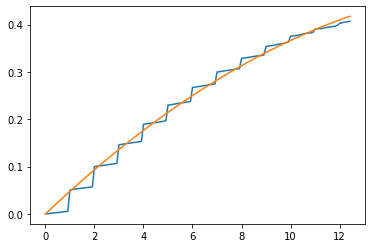

In [128]:
plt.plot(cumHazDF.years, cumHazDF.baselineHazard)
plt.plot(cumHazDF.years, cumHazDF.predHazard)

count   242277.0000
mean         1.3663
std          1.1948
min          0.2754
25%          0.5507
50%          0.8937
75%          1.7717
max         14.0298
Name: partialHazard, dtype: float64


<AxesSubplot:>

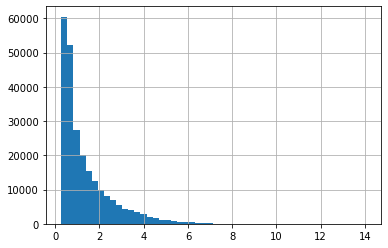

In [155]:
print(ctvDF.partialHazard.describe())
ctvDF.partialHazard.hist(bins=50)

In [142]:
ctvDF['age10'] = pd.qcut(ctvDF.age, 10)
ctvDF.groupby('age10')['partialHazard'].describe()

/var/folders/wd/wlg9qv65701fzmgdkdfy5vtm0000gr/T/ipykernel_32156/229217975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctvDF['age10'] = pd.qcut(ctvDF.age, 10)


,count,mean,std,min,25%,50%,75%,max
age10,,,,,,,,
"(17.999, 24.0]",25459.0000,1.3644,1.1736,0.3047,0.5559,0.8931,1.7824,12.1361
"(24.0, 29.0]",24150.0000,1.3655,1.1921,0.2808,0.5513,0.8802,1.7963,12.1361
"(29.0, 35.0]",25183.0000,1.3611,1.1805,0.2808,0.5461,0.8786,1.7722,13.4896
"(35.0, 41.0]",23795.0000,1.3534,1.2015,0.2808,0.5421,0.8609,1.7323,13.6067
"(41.0, 47.0]",23305.0000,1.3537,1.2119,0.2922,0.5508,0.8717,1.7479,13.6067
"(47.0, 54.0]",25653.0000,1.3733,1.2111,0.2922,0.5516,0.9050,1.7890,13.6067
"(54.0, 62.0]",24654.0000,1.3944,1.2234,0.2978,0.5557,0.9283,1.8186,14.0298
"(62.0, 69.0]",22251.0000,1.3718,1.2127,0.2984,0.5532,0.9076,1.7760,14.0298
"(69.0, 78.0]",24927.0000,1.3621,1.1619,0.2754,0.5537,0.9191,1.7438,12.4814


In [149]:
ctvDF.groupby('mi')['partialHazard'].describe()

,count,mean,std,min,25%,50%,75%,max
mi,,,,,,,,
0,233755.0000,1.3658,1.1941,0.2754,0.5507,0.8934,1.7697,14.0298
1,8522.0000,1.3791,1.2137,0.2923,0.5533,0.9061,1.8013,10.3914


In [134]:
import sys
import os
sys.path.append(os.path.abspath("../microsim/"))
from microsim.cox_regression_model import CoxRegressionModel


coxModelExport = CoxRegressionModel(dict(ctv.params_),
                              dict(ctv.standard_errors_), 
                              cumHazardQuadResult.params['years'] , cumHazardQuadResult.params['yearsSquared'] )

coxModelExport.write_json(os.path.abspath("../microsim/microsim/data/nhanesMortalityModelSpecTVC.json"))

### In the calibration, we find that we're-over-predicting mortality in the simluation. 

Possible explanations:
<ul>
    <li> Bad model fit in NHANES</li>
    <li> Misimplementaiton of cumulative hazard logic</li>
    <li> Misimplementaiton of the one year aggregation of the cumulative hazard</li>
    <li> Coding Error </li>
</ul>

## first, let's check that the model is well-calibrated against itself...

In [12]:
cumHazardPredicted = coxModel.predict(results.params, pred_type='cumhaz').predicted_values
betaOutput = coxModel.predict(results.params, pred_type='lhr').predicted_values

In [13]:
imputedDataset['monthsToDeath'] = imputedDataset['monthsToDeath'].astype(int)
imputedDataset['monthsToDeath'].loc[imputedDataset['monthsToDeath'] >=149] = 149
imputedDataset['cumHazardAt2011'] = cumHaz[imputedDataset.monthsToDeath]
imputedDataset['estimatedCumHazardAt2011'] = cumHazardQuadResult.params[0] * imputedDataset.monthsToDeath/12 + cumHazardQuadResult.params[1] * (imputedDataset.monthsToDeath/12)**2

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
imputedDataset['cumHazardPredicted'] = cumHazardPredicted
imputedDataset['betaOutput'] = betaOutput
imputedDataset['calcCumHazard'] = imputedDataset.cumHazardAt2011 * np.exp(imputedDataset.betaOutput)
imputedDataset['calcCumHazardUsingEstimation'] = imputedDataset.estimatedCumHazardAt2011 * np.exp(imputedDataset.betaOutput)
imputedDataset['delta'] = imputedDataset.cumHazardPredicted - imputedDataset.calcCumHazard

In [15]:
imputedDataset.groupby('nonCVDeath')['delta'].describe() 

,count,mean,std,min,25%,50%,75%,max
nonCVDeath,,,,,,,,
False,31622.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
True,2280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### So, we've checked that our calculattion of the cumulative hazard lines up with what the model predicts...

                nonCVDeath  calcCumHazard  calcCumHazardUsingEstimation  \
ageDecile                                                                 
(18.999, 23.0]    0.004663       0.004043                      0.004031   
(23.0, 29.0]      0.004434       0.005707                      0.005686   
(29.0, 35.0]      0.006075       0.007818                      0.007785   
(35.0, 41.0]      0.011405       0.011991                      0.011943   
(41.0, 47.0]      0.018210       0.018180                      0.018110   
(47.0, 54.0]      0.033816       0.029385                      0.029232   
(54.0, 61.0]      0.058523       0.050436                      0.050188   
(61.0, 69.0]      0.094791       0.093588                      0.093131   
(69.0, 77.0]      0.157726       0.165606                      0.164899   
(77.0, 85.0]      0.297101       0.287185                      0.285344   

                  baseAge  
ageDecile                  
(18.999, 23.0]  20.570466  
(23.0, 29.0]   

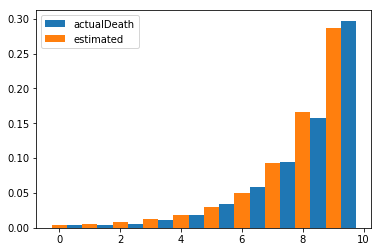

In [16]:
imputedDataset['ageDecile'] = pd.qcut(imputedDataset.baseAge, 10)
output = imputedDataset.groupby('ageDecile')[['nonCVDeath', 'calcCumHazard', 'calcCumHazardUsingEstimation', 'baseAge']].mean()
print(output)
plt.bar(output.index.codes+0.5, output.nonCVDeath, width=0.5, label="actualDeath")
plt.bar(output.index.codes, output.calcCumHazard, width=0.5, label="estimated")
plt.legend()

### So, we do not have a fundamental failure of model calibration...it looks pretty good in the sample it was derived from. Also, we tested our quadratic estimate on the baseline hazard and it looks like it also performs well.

However there was one interesting potential lesson here — if the times to event are a little bit off it can lead to very different conclusions. 

### One other thing to check that came up when validating the overall simulation against NHANES...is there under-prediciton in teh oldest old under long follow-up? Let's specifically check

In [17]:
earlyCrossSectionOfNonImmigrants = pd.read_stata("/Users/burke/Documents/research/bpCog/nhanes/earlyCrossSectionOfNonImmigrants.dta")
earlyCrossSectionOfNonImmigrants['ageDecile'] = pd.qcut(earlyCrossSectionOfNonImmigrants.age, 10)
earlyCrossSectionOfNonImmigrants['squareBaseAge'] = earlyCrossSectionOfNonImmigrants.age**2

earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.rename({'selfReportMI' : 'mi', 
                                        'selfReportStroke' : 'stroke', 
                                        'tot_chol' : 'totChol',
                                        'meanDBP' : 'meanDbp',
                                        'meanSBP' : 'meanSbp',
                                        'age' : 'baseAge'}, axis='columns')
earlyCrossSectionOfNonImmigrants['nonCVDeath'] = earlyCrossSectionOfNonImmigrants.ucod == 3



earlyCrossSectionOfNonImmigrants = pd.concat([earlyCrossSectionOfNonImmigrants, pd.get_dummies(earlyCrossSectionOfNonImmigrants.raceEthnicity, prefix='raceEthnicity')], axis=1)
earlyCrossSectionOfNonImmigrants = pd.concat([earlyCrossSectionOfNonImmigrants, pd.get_dummies(earlyCrossSectionOfNonImmigrants.smokingStatus, prefix='smokingStatus')], axis=1)

In [18]:
variablesForModel = earlyCrossSectionOfNonImmigrants[['raceEthnicity_2', 'raceEthnicity_3', 'raceEthnicity_4', 'raceEthnicity_5', 'smokingStatus_1', 'smokingStatus_2','baseAge', 'squareBaseAge', 'a1c','bmi','gender', 'hdl', 'ldl','mi','stroke', 'totChol', 'trig', 'meanSbp', 'meanDbp']]

cumHazardPredicted = coxModel.predict(results.params, exog=variablesForModel, endog=earlyCrossSectionOfNonImmigrants.monthsToDeath,
                                      pred_type='cumhaz').predicted_values
earlyCrossSectionOfNonImmigrants['cumHazardPredicted'] = cumHazardPredicted

                nonCVDeath  cumHazardPredicted
ageDecile                                     
(20.999, 25.0]    0.018219            0.008526
(25.0, 30.0]      0.017928            0.010075
(30.0, 36.0]      0.008818            0.013982
(36.0, 40.0]      0.059809            0.019294
(40.0, 45.0]      0.015929            0.026068
(45.0, 49.0]      0.017582            0.037265
(49.0, 54.0]      0.044574            0.053054
(54.0, 61.0]      0.069264            0.083623
(61.0, 72.0]      0.136842            0.163590
(72.0, 85.0]      0.357447            0.329762


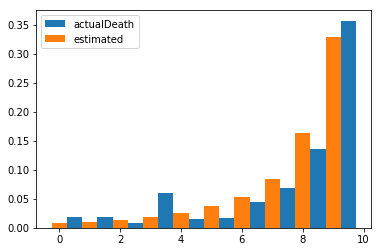

In [19]:
output = earlyCrossSectionOfNonImmigrants.groupby('ageDecile')[['nonCVDeath', 'cumHazardPredicted']].mean()
print(output)
plt.bar(output.index.codes+0.5, output.nonCVDeath, width=0.5, label="actualDeath")
plt.bar(output.index.codes, output.cumHazardPredicted, width=0.5, label="estimated")
plt.legend()

### Doesn't look like it — using the NHANES based dataset (earlyImmigrants) for comparison of long term mortality and then running the predictions using the model estiamted here, we're getting very similar predictions to what we saw in the whle sample...

### So, the next step is to run the model on these same data and comapre...first, we'll run the model with our implementtation of the cox model. THen we'll run the markov-ed version

In [20]:
from mcm.gender import NHANESGender
from mcm.person import Person
from mcm.outcome import Outcome
from mcm.race_ethnicity import NHANESRaceEthnicity
from mcm.smoking_status import SmokingStatus
from mcm.cohort_risk_model_repository import CohortRiskModelRepository
from mcm.outcome_model_repository import OutcomeModelRepository

In [21]:
import os 

cohortModel = OutcomeModelRepository()
riskModel = CohortRiskModelRepository()

def calcMortalityRunningFullModel(x):
        temp =  Person(
            age=x.baseAge,
            gender=NHANESGender(int(x.gender)),
            raceEthnicity=NHANESRaceEthnicity(int(x.raceEthnicity)),
            sbp=x.meanSbp,
            dbp=x.meanDbp,
            a1c=x.a1c,
            hdl=x.hdl,
            ldl=x.ldl,
            trig=x.trig,
            totChol=x.totChol,
            bmi=x.bmi,
            smokingStatus=SmokingStatus(int(x.smokingStatus)),
            dfIndex=x.index,
            diedBy2011=x.diedBy2011)
        
        for year in range(1,11):
            if not temp.is_dead():
                temp.advance_year(riskModel, cohortModel)
        return temp.is_dead() and not temp.has_fatal_mi() and not temp.has_fatal_stroke()


earlyCrossSectionOfNonImmigrants['estMortalityFromModel'] = earlyCrossSectionOfNonImmigrants.apply(calcMortalityRunningFullModel, axis=1)

                nonCVDeath  cumHazardPredicted  estMortalityFromModel
ageDecile                                                            
(20.999, 25.0]    0.018219            0.008526               0.004049
(25.0, 30.0]      0.017928            0.010075               0.005976
(30.0, 36.0]      0.008818            0.013982               0.015873
(36.0, 40.0]      0.059809            0.019294               0.011962
(40.0, 45.0]      0.015929            0.026068               0.028319
(45.0, 49.0]      0.017582            0.037265               0.030769
(49.0, 54.0]      0.044574            0.053054               0.052326
(54.0, 61.0]      0.069264            0.083623               0.073593
(61.0, 72.0]      0.136842            0.163590               0.176842
(72.0, 85.0]      0.357447            0.329762               0.427660


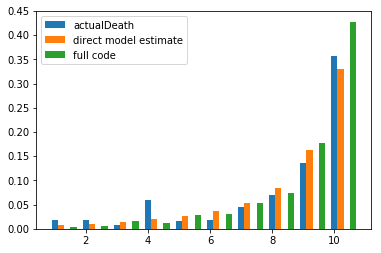

In [22]:
output = earlyCrossSectionOfNonImmigrants.groupby('ageDecile')[['nonCVDeath', 'cumHazardPredicted',  'estMortalityFromModel']].mean()
print(output)
plt.bar(output.index.codes+1, output.nonCVDeath, width=0.20, label="actualDeath")
plt.bar(output.index.codes+1.2, output.cumHazardPredicted, width=0.20, label="direct model estimate")
plt.bar(output.index.codes+1.6, output.estMortalityFromModel, width=0.20, label="full code")

plt.legend()

### Ok...this is telling the story, i think...
1. there is a small problem witht eh green bars — rthey should be exactly the same as the orange bars or extremely close.
 to figure that out, we can just esetimat ethe linear predictors and hazard functions for both and compare
2. the bigger problem si that the red bars are over-estimating risk. its conceivable that whatefger the problem in #1 is is being amplified
, but its more likely thtat there is something wrong about aggregating over time...

In [24]:
def calcLinearPredictorUsingModel(x):
    temp =  Person(
            age=x.baseAge,
            gender=NHANESGender(int(x.gender)),
            raceEthnicity=NHANESRaceEthnicity(int(x.raceEthnicity)),
            sbp=x.meanSbp,
            dbp=x.meanDbp,
            a1c=x.a1c,
            hdl=x.hdl,
            ldl=x.ldl,
            trig=x.trig,
            totChol=x.totChol,
            bmi=x.bmi,
            smokingStatus=SmokingStatus(int(x.smokingStatus)),
            dfIndex=x.index,
            diedBy2011=x.diedBy2011)
    return statsModel.linear_predictor(temp)

def calcCumHazardUsingModel(x):
    temp =  Person(
            age=x.baseAge,
            gender=NHANESGender(int(x.gender)),
            raceEthnicity=NHANESRaceEthnicity(int(x.raceEthnicity)),
            sbp=x.meanSbp,
            dbp=x.meanDbp,
            a1c=x.a1c,
            hdl=x.hdl,
            ldl=x.ldl,
            trig=x.trig,
            totChol=x.totChol,
            bmi=x.bmi,
            smokingStatus=SmokingStatus(int(x.smokingStatus)),
            dfIndex=x.index,
            diedBy2011=x.diedBy2011)
    return statsModel.get_cumulative_hazard_for_interval(0, x.monthsToDeath/12)

cohortModel = OutcomeModelRepository()
riskModel = CohortRiskModelRepository()

earlyCrossSectionOfNonImmigrants['estLinearPredictorFromOurCode'] = earlyCrossSectionOfNonImmigrants.apply(calcLinearPredictorUsingModel, axis=1)
earlyCrossSectionOfNonImmigrants['estCumHazardFromOurCode'] = earlyCrossSectionOfNonImmigrants.apply(calcCumHazardUsingModel, axis=1)


In [27]:
variablesForModel = earlyCrossSectionOfNonImmigrants[['raceEthnicity_2', 'raceEthnicity_3', 'raceEthnicity_4', 'raceEthnicity_5', 'smokingStatus_1', 'smokingStatus_2','baseAge', 'squareBaseAge', 'a1c','bmi','gender', 'hdl', 'ldl','mi','stroke', 'totChol', 'trig', 'meanSbp', 'meanDbp']]

linearPredictorPredicted = coxModel.predict(results.params, exog=variablesForModel, endog=earlyCrossSectionOfNonImmigrants.monthsToDeath,
                                      pred_type='lhr').predicted_values
earlyCrossSectionOfNonImmigrants['linearPredictorFromCox'] = linearPredictorPredicted
earlyCrossSectionOfNonImmigrants['baselineHazardFromCox'] = cumHaz[earlyCrossSectionOfNonImmigrants.monthsToDeath.astype(int)]

                linearPredictorFromCox  estLinearPredictorFromOurCode
ageDecile                                                            
(20.999, 26.0]                1.003385                       1.000636
(26.0, 31.0]                  1.157677                       1.155450
(31.0, 36.0]                  1.342369                       1.333863
(36.0, 40.0]                  1.671952                       1.663334
(40.0, 45.0]                  1.841432                       1.833784
(45.0, 49.0]                  2.232966                       2.224690
(49.0, 54.0]                  2.563518                       2.540487
(54.0, 60.0]                  2.920201                       2.892655
(60.0, 72.0]                  3.715388                       3.657640
(72.0, 85.0]                  5.092387                       4.946215


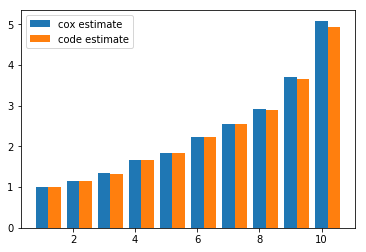

In [28]:
output = earlyCrossSectionOfNonImmigrants.groupby('ageDecile')[['linearPredictorFromCox', 'estLinearPredictorFromOurCode']].mean()
print(output)
plt.bar(output.index.codes+1, output.linearPredictorFromCox, width=0.40, label="cox estimate")
plt.bar(output.index.codes+1.4, output.estLinearPredictorFromOurCode, width=0.40, label="code estimate")

plt.legend()

                estCumHazardFromOurCode  baselineHazardFromCox
ageDecile                                                     
(20.999, 26.0]                 0.005613               0.005576
(26.0, 31.0]                   0.005532               0.005495
(31.0, 36.0]                   0.005569               0.005529
(36.0, 40.0]                   0.005489               0.005454
(40.0, 45.0]                   0.005521               0.005488
(45.0, 49.0]                   0.005417               0.005392
(49.0, 54.0]                   0.005377               0.005344
(54.0, 60.0]                   0.005385               0.005359
(60.0, 72.0]                   0.004932               0.004897
(72.0, 85.0]                   0.003521               0.003509


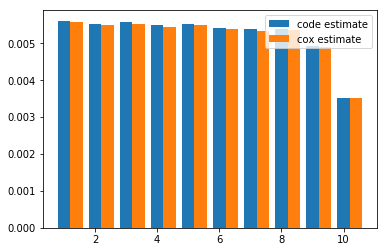

In [30]:
output = earlyCrossSectionOfNonImmigrants.groupby('ageDecile')[['estCumHazardFromOurCode', 'baselineHazardFromCox']].mean()
print(output)
plt.bar(output.index.codes+1, output.estCumHazardFromOurCode, width=0.40, label="code estimate")
plt.bar(output.index.codes+1.4, output.baselineHazardFromCox, width=0.40, label="cox estimate")

plt.legend()